# Homework 2: Two ways with MIMIC-III
### Jonathan Wu
### Due: 5/9/2025

#### Part I (Relational)
1. Load all the data into a duckdb database. Refer to MIMIC-III example for guidance to create your own database.
2. Answer the following analysis questions along with your queries.
For each question, provide the following four pieces of information:
<br>a. the SQL query,
<br>b. brief explanation of the query (i.e., what operations are performed by the major parts of the query),
<br>c. the first several lines of your resulting table, and
<br>d. a summary of your findings. If it benefits to use a graph, include your graph at the end of your answer, with clear labels and caption.

The analysis questions are:

1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.
2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.
3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

In [1]:
#!pip install duckdb==1.2.2
import duckdb
import pandas as pd

In [2]:
conn = duckdb.connect('mimic.db', read_only=False)

conn.sql('SHOW TABLES;')

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ ADMISSIONS    │
│ DRGCODES      │
│ D_ICD         │
│ ICUSTAYS      │
│ PATIENTS      │
│ PRESCRIPTIONS │
│ PROD_ICD      │
└───────────────┘

In [3]:
df = pd.read_csv("PRESCRIPTIONS.csv", index_col="row_id")
df.head()

,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
row_id,,,,,,,,,,,,,,,,,,
32600,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Pneumococcal Vac Polyvalent,Pneumococcal Vac Polyvalent,PNEUMOcoccal Vac Polyvalent,PNEU25I,48548.0,6494300.0,25mcg/0.5mL Vial,0.5,mL,1,VIAL,IM
32601,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Bisacodyl,Bisacodyl,Bisacodyl,BISA5,2947.0,536338101.0,5 mg Tab,10,mg,2,TAB,PO
32602,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Bisacodyl,Bisacodyl,Bisacodyl (Rectal),BISA10R,2944.0,574705050.0,10mg Suppository,10,mg,1,SUPP,PR
32603,42458,159647,NaN,2146-07-21 00:00:00,2146-07-22 00:00:00,MAIN,Senna,Senna,Senna,SENN187,19964.0,904516561.0,1 Tablet,1,TAB,1,TAB,PO
32604,42458,159647,NaN,2146-07-21 00:00:00,2146-07-21 00:00:00,MAIN,Docusate Sodium (Liquid),Docusate Sodium (Liquid),Docusate Sodium (Liquid),DOCU100L,3017.0,121054410.0,100mg UD Cup,100,mg,1,UDCUP,PO


In [7]:
try:
    df.to_sql("PRESCRIPTIONS", conn, index=False)
except:
    print("Already there")

Already there


/tmp/ipykernel_107/2236051402.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df.to_sql("PRESCRIPTIONS", conn, index=False)


In [ ]:
files = ["ADMISSIONS", "D_ICD_PROCEDURES", "DRGCODES", 
         'ICUSTAYS','PATIENTS', 'PROCEDURES_ICD']
file_names = ["ADMISSIONS", "D_ICD", "DRGCODES", 'ICUSTAYS', 'PATIENTS', 'PROD_ICD']
for i in range(len(files)):
    df = pd.read_csv(files[i]+".csv", index_col = 'row_id')
    # try except clause is because I messed up a file name, didn't want to restart jupyter notebook
    try:
        df.to_sql(file_names[i], conn, index=False)
    except:
        continue


In [ ]:
conn.close()

In [ ]:
conn = duckdb.connect('mimic.db')

conn.sql('SHOW TABLES;')

#### Part I Question 1
Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

In [5]:
conn.sql(
    """
    SELECT ethnicity, drug, dose_val_rx, dose_unit_rx, count(drug) as prescription_count
    FROM ADMISSIONS
    JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
    GROUP BY ethnicity, drug, dose_val_rx, dose_unit_rx
    ORDER BY prescription_count DESC
    LIMIT 5;
    """
)

┌────────────────────────────────┬──────────────────────────────────────┬─────────────┬──────────────┬────────────────────┐
│           ethnicity            │                 drug                 │ dose_val_rx │ dose_unit_rx │ prescription_count │
│            varchar             │               varchar                │   varchar   │   varchar    │       int64        │
├────────────────────────────────┼──────────────────────────────────────┼─────────────┼──────────────┼────────────────────┤
│ HISPANIC/LATINO - PUERTO RICAN │ 0.9% Sodium Chloride (Mini Bag Plus) │ 100         │ mL           │                465 │
│ HISPANIC/LATINO - PUERTO RICAN │ 0.9% Sodium Chloride                 │ 1000        │ mL           │                420 │
│ HISPANIC/LATINO - PUERTO RICAN │ Potassium Chloride                   │ 40          │ mEq          │                390 │
│ HISPANIC/LATINO - PUERTO RICAN │ Insulin                              │ 0           │ UNIT         │                375 │
│ HISPAN

Going to need to grab admissions for ethnicity and prescriptions

https://www.geeksforgeeks.org/how-to-select-the-first-row-of-each-group-by-in-sql/

In [6]:
conn.sql(
    """
    SELECT ethnicity, drug, dose_val_rx, dose_unit_rx, prescription_count
    FROM (
        SELECT
            ADMISSIONS.ethnicity,
            PRESCRIPTIONS.drug,
            PRESCRIPTIONS.dose_val_rx,
            PRESCRIPTIONS.dose_unit_rx,
            COUNT(*) AS prescription_count,
            ROW_NUMBER() OVER (
                PARTITION BY ADMISSIONS.ethnicity
                ORDER BY COUNT(*) DESC
            ) AS rank
        FROM ADMISSIONS
        JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
        GROUP BY
            ADMISSIONS.ethnicity,
            PRESCRIPTIONS.drug,
            PRESCRIPTIONS.dose_val_rx,
            PRESCRIPTIONS.dose_unit_rx
    )
    WHERE rank = 1
    ORDER BY ethnicity;
    """
)


┌──────────────────────────────────────────────────────────┬──────────────────────────────────────┬─────────────┬──────────────┬────────────────────┐
│                        ethnicity                         │                 drug                 │ dose_val_rx │ dose_unit_rx │ prescription_count │
│                         varchar                          │               varchar                │   varchar   │   varchar    │       int64        │
├──────────────────────────────────────────────────────────┼──────────────────────────────────────┼─────────────┼──────────────┼────────────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │ 5% Dextrose                          │ 1000        │ mL           │                 30 │
│ ASIAN                                                    │ D5W                                  │ 250         │ ml           │                 14 │
│ BLACK/AFRICAN AMERICAN                                   │ Insulin                              │ 

In [7]:
df = conn.sql(
    """
    SELECT
        ADMISSIONS.ethnicity,
        PRESCRIPTIONS.drug,
        SUM(CAST(PRESCRIPTIONS.dose_val_rx AS INT)) AS total_dose,
        dose_unit_rx
    FROM ADMISSIONS
    JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
    WHERE PRESCRIPTIONS.dose_val_rx ~ '^\\d+(\\.\\d+)?$'
    GROUP BY ADMISSIONS.ethnicity, PRESCRIPTIONS.drug, PRESCRIPTIONS.dose_unit_rx
    ORDER BY ethnicity, total_dose DESC;
    """
).df()
df.head()


,ethnicity,drug,total_dose,dose_unit_rx
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,33800.0,mL
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Heparin,30000.0,UNIT
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,0.9% Sodium Chloride,27200.0,mL
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Lactulose Enema,10000.0,mL
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Vancomycin,8000.0,mg


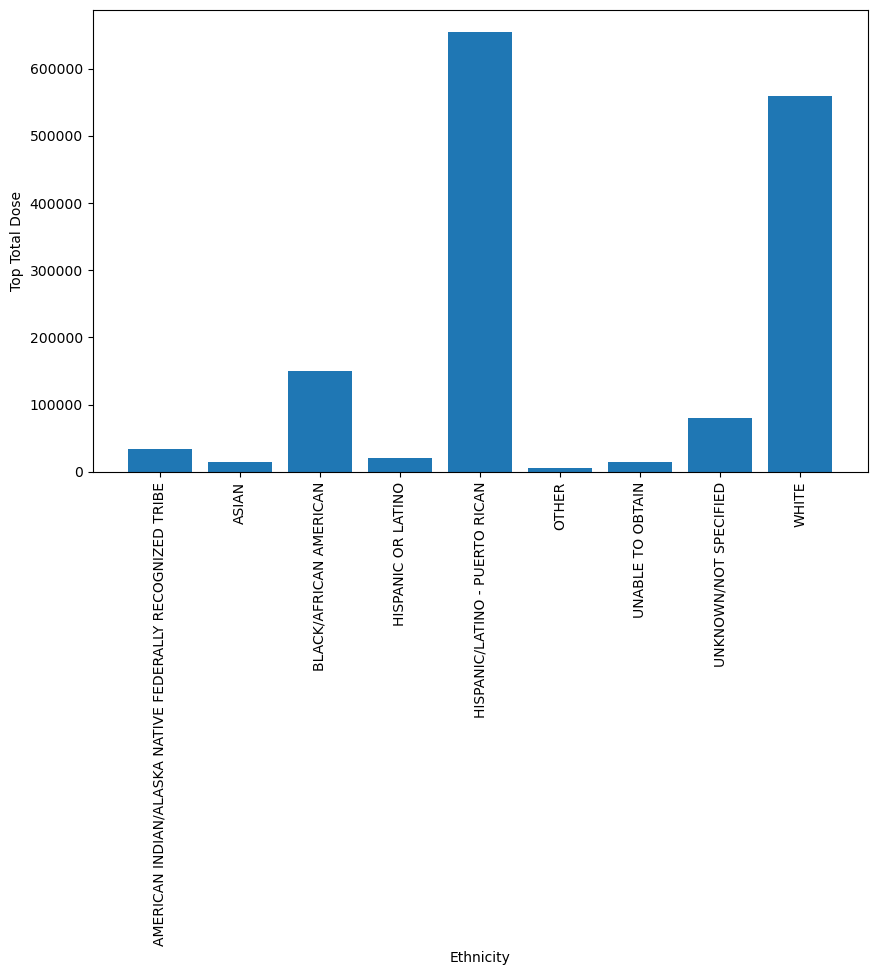

In [8]:
import matplotlib.pyplot as plt

top_doses = df.groupby('ethnicity')['total_dose'].max().reset_index()
plt.figure(figsize=(10,6))
plt.bar(top_doses['ethnicity'], top_doses['total_dose'])
plt.xlabel("Ethnicity")
plt.ylabel("Top Total Dose")
plt.xticks(rotation = 90)
plt.show()

#### Part I Question 2
Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.

In [9]:
conn.sql(
    """
    SELECT * FROM PATIENTS LIMIT 2;
    """
)

┌────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────┐
│ subject_id │ gender  │         dob         │         dod         │      dod_hosp       │       dod_ssn       │ expire_flag │
│   int32    │ varchar │       varchar       │       varchar       │       varchar       │       varchar       │    int32    │
├────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│      10006 │ F       │ 2094-03-05 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │           1 │
│      10011 │ F       │ 2090-06-05 00:00:00 │ 2126-08-28 00:00:00 │ 2126-08-28 00:00:00 │ NULL                │           1 │
└────────────┴─────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────┘

In [10]:
conn.sql(
    """
    SELECT * FROM ADMISSIONS LIMIT 2;
    """
)

┌────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬────────────────┬───────────────────────────┬────────────────────┬───────────┬──────────┬──────────┬────────────────┬────────────────────────┬─────────────────────┬─────────────────────┬─────────────┬──────────────────────┬──────────────────────┐
│ subject_id │ hadm_id │      admittime      │      dischtime      │      deathtime      │ admission_type │    admission_location     │ discharge_location │ insurance │ language │ religion │ marital_status │       ethnicity        │      edregtime      │      edouttime      │  diagnosis  │ hospital_expire_flag │ has_chartevents_data │
│   int32    │  int32  │       varchar       │       varchar       │       varchar       │    varchar     │          varchar          │      varchar       │  varchar  │ varchar  │ varchar  │    varchar     │        varchar         │       varchar       │       varchar       │   varchar   │        int32         │        int32

In [11]:
conn.sql(
    """
    SELECT * FROM PROD_ICD LIMIT 2;
    """
)

┌────────────┬─────────┬─────────┬───────────┐
│ subject_id │ hadm_id │ seq_num │ icd9_code │
│   int32    │  int32  │  int32  │   int32   │
├────────────┼─────────┼─────────┼───────────┤
│      10114 │  167957 │       1 │      3605 │
│      10114 │  167957 │       2 │      3722 │
└────────────┴─────────┴─────────┴───────────┘

In [12]:
conn.sql(
    """
    SELECT * FROM D_ICD LIMIT 2;
    """
)

┌───────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ icd9_code │       short_title        │                            long_title                             │
│   int32   │         varchar          │                              varchar                              │
├───────────┼──────────────────────────┼───────────────────────────────────────────────────────────────────┤
│      1423 │ Chorioret les xenon coag │ Destruction of chorioretinal lesion by xenon arc photocoagulation │
│      1424 │ Chorioret les laser coag │ Destruction of chorioretinal lesion by laser photocoagulation     │
└───────────┴──────────────────────────┴───────────────────────────────────────────────────────────────────┘

In [13]:
conn.sql(
    """
    SELECT date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) as age
    FROM PATIENTS
    JOIN ADMISSIONS ON PATIENTS.subject_id=ADMISSIONS.subject_id
    LIMIT 10;
    """
)

┌───────┐
│  age  │
│ int64 │
├───────┤
│    70 │
│    36 │
│    87 │
│    74 │
│    49 │
│   300 │
│    82 │
│    78 │
│    88 │
│    81 │
└───────┘

In [14]:
conn.sql(
    """
    SELECT CASE
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <50 THEN 'ADULT'
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >=50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
    ELSE 'ELDERLY'
    END AS age_group,
    FROM PATIENTS
    JOIN ADMISSIONS ON PATIENTS.subject_id=ADMISSIONS.subject_id
    JOIN PROD_ICD ON ADMISSIONS.hadm_id=PROD_ICD.hadm_id
    JOIN D_ICD ON PROD_ICD.ICD9_CODE=D_ICD.ICD9_CODE
    GROUP BY age_group
    LIMIT 5;
    """
)

┌───────────┐
│ age_group │
│  varchar  │
├───────────┤
│ OLD       │
│ ADULT     │
│ ELDERLY   │
│ MINOR     │
└───────────┘

In [15]:
df2 = conn.sql(
    """
    SELECT *
    FROM (
        SELECT
            CASE
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                ELSE 'ELDERLY'
            END AS age_group,
            long_title,
            COUNT(*) AS procedure_count,
            ROW_NUMBER() OVER (
                PARTITION BY
                    CASE
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                        ELSE 'ELDERLY'
                    END
                ORDER BY COUNT(*) DESC
            ) AS rank
        FROM PATIENTS
        JOIN ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
        JOIN PROD_ICD ON ADMISSIONS.hadm_id = PROD_ICD.hadm_id
        JOIN D_ICD ON PROD_ICD.ICD9_CODE = D_ICD.ICD9_CODE
        GROUP BY age_group, long_title
    ) ranked
    WHERE rank <= 3
    ORDER BY age_group, procedure_count DESC;
    """
).df()
df2

,age_group,long_title,procedure_count,rank
0,ADULT,"Venous catheterization, not elsewhere classified",9,1
1,ADULT,Enteral infusion of concentrated nutritional s...,7,2
2,ADULT,Insertion of endotracheal tube,6,3
3,ELDERLY,"Venous catheterization, not elsewhere classified",20,1
4,ELDERLY,Transfusion of packed cells,13,2
5,ELDERLY,Insertion of endotracheal tube,8,3
6,MINOR,"Venous catheterization, not elsewhere classified",2,1
7,MINOR,Repair of vertebral fracture,1,2
8,MINOR,Interruption of the vena cava,1,3
9,OLD,"Venous catheterization, not elsewhere classified",25,1


#### Part I Question 3
How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

https://duckdb.org/docs/stable/sql/data_types/typecasting

https://duckdb.org/docs/stable/sql/data_types/interval

https://duckdb.org/docs/stable/sql/functions/datepart.html

https://duckdb.org/docs/stable/sql/functions/interval.html

In [16]:
conn.sql(
    """
    SELECT * FROM PATIENTS LIMIT 5;
    """
)

┌────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────┐
│ subject_id │ gender  │         dob         │         dod         │      dod_hosp       │       dod_ssn       │ expire_flag │
│   int32    │ varchar │       varchar       │       varchar       │       varchar       │       varchar       │    int32    │
├────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│      10006 │ F       │ 2094-03-05 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │           1 │
│      10011 │ F       │ 2090-06-05 00:00:00 │ 2126-08-28 00:00:00 │ 2126-08-28 00:00:00 │ NULL                │           1 │
│      10013 │ F       │ 2038-09-03 00:00:00 │ 2125-10-07 00:00:00 │ 2125-10-07 00:00:00 │ 2125-10-07 00:00:00 │           1 │
│      10017 │ F       │ 2075-09-21 00:00:00 │ 2152-09-12 00:00:00 │ NULL                │ 2152-09-12 00:00:00 

In [17]:
conn.sql("""
SELECT * FROM ICUSTAYS LIMIT 5""")

┌────────────┬─────────┬────────────┬──────────┬────────────────┬───────────────┬──────────────┬─────────────┬─────────────────────┬─────────────────────┬─────────┐
│ subject_id │ hadm_id │ icustay_id │ dbsource │ first_careunit │ last_careunit │ first_wardid │ last_wardid │       intime        │       outtime       │   los   │
│   int32    │  int32  │   int32    │ varchar  │    varchar     │    varchar    │    int32     │    int32    │       varchar       │       varchar       │  float  │
├────────────┼─────────┼────────────┼──────────┼────────────────┼───────────────┼──────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────┤
│      10006 │  142345 │     206504 │ carevue  │ MICU           │ MICU          │           52 │          52 │ 2164-10-23 21:10:15 │ 2164-10-25 12:21:07 │  1.6325 │
│      10011 │  105331 │     232110 │ carevue  │ MICU           │ MICU          │           15 │          15 │ 2126-08-14 22:34:00 │ 2126-08-28 18:59:00 │ 13.8507 │
│      100

In [18]:
conn.sql("""
SELECT avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS""")

┌────────────────────┐
│  remaining_hours   │
│       double       │
├────────────────────┤
│ 106.85906658496732 │
└────────────────────┘

In [19]:
conn.sql("""
SELECT gender, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS JOIN PATIENTS on ICUSTAYS.subject_id=PATIENTS.subject_id GROUP BY gender""")

┌─────────┬────────────────────┐
│ gender  │  remaining_hours   │
│ varchar │       double       │
├─────────┼────────────────────┤
│ F       │ 132.96187389770722 │
│ M       │  84.33198630136985 │
└─────────┴────────────────────┘

In [20]:
conn.sql("""
SELECT ethnicity, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS JOIN ADMISSIONS on ICUSTAYS.subject_id=ADMISSIONS.subject_id GROUP BY ethnicity""")

┌──────────────────────────────────────────────────────────┬────────────────────┐
│                        ethnicity                         │  remaining_hours   │
│                         varchar                          │       double       │
├──────────────────────────────────────────────────────────┼────────────────────┤
│ BLACK/AFRICAN AMERICAN                                   │  164.8246296296296 │
│ UNKNOWN/NOT SPECIFIED                                    │ 108.25615384615385 │
│ WHITE                                                    │  98.95345400728597 │
│ OTHER                                                    │ 22.225740740740743 │
│ ASIAN                                                    │           93.36125 │
│ HISPANIC OR LATINO                                       │  179.0312962962963 │
│ HISPANIC/LATINO - PUERTO RICAN                           │  77.83348148148148 │
│ UNABLE TO OBTAIN                                         │ 320.56888888888886 │
│ AMERICAN INDIA

In [21]:
df3= conn.sql("""
SELECT ethnicity, gender, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS hospise_time
FROM ICUSTAYS 
JOIN PATIENTS on ICUSTAYS.subject_id=PATIENTS.subject_id
JOIN ADMISSIONS on ICUSTAYS.subject_id=ADMISSIONS.subject_id GROUP BY ethnicity, gender""").df()
df3

,ethnicity,gender,hospise_time
0,BLACK/AFRICAN AMERICAN,F,268.829792
1,UNKNOWN/NOT SPECIFIED,F,118.577020
2,WHITE,F,120.412821
3,WHITE,M,83.012210
4,OTHER,M,2.542222
5,ASIAN,M,170.815278
6,BLACK/AFRICAN AMERICAN,M,81.620500
7,OTHER,F,32.067500
8,ASIAN,F,15.907222
9,UNKNOWN/NOT SPECIFIED,M,51.491389


## Part 2


In [31]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0   5543      0 --:--:-- --:--:-- --:--:--  5560


In [8]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(
    region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_105/1196366822.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [9]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [10]:
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

In [11]:
# establishing connection to Keyspace
session = cluster.connect()

NoHostAvailable: ('Unable to connect to any servers', {'3.12.23.146:9142': ValueError("Can't authenticate without a region name")})

### Part 1

In [63]:
# For example, create a keyspace for HW2
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS part1 
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

NameError: name 'session' is not defined

In [ ]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('de300_demo')  # Replace with your keyspace

In [57]:
part1 = conn.sql("""
SELECT * FROM ADMISSIONS
JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
""").df()
part1.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,...,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
0,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,...,PNEUMOcoccal Vac Polyvalent,PNEU25I,48548.0,6494300.0,25mcg/0.5mL Vial,0.5,mL,1,VIAL,IM
1,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,...,Bisacodyl,BISA5,2947.0,536338112.0,5 mg Tab,10,mg,2,TAB,PO
2,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,...,Bisacodyl (Rectal),BISA10R,2944.0,574705024.0,10mg Suppository,10,mg,1,SUPP,PR
3,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,...,Senna,SENN187,19964.0,904516544.0,1 Tablet,1,TAB,1,TAB,PO
4,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,...,Docusate Sodium (Liquid),DOCU100L,3017.0,121054408.0,100mg UD Cup,100,mg,1,UDCUP,PO


In [ ]:
cluster = Cluster(

### Part 2

In [58]:
part2 = conn.sql("""
FROM PATIENTS
        JOIN ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
        JOIN PROD_ICD ON ADMISSIONS.hadm_id = PROD_ICD.hadm_id
        JOIN D_ICD ON PROD_ICD.ICD9_CODE = D_ICD.ICD9_CODE""").df()
part2.head()

,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,subject_id_1,hadm_id,admittime,...,diagnosis,hospital_expire_flag,has_chartevents_data,subject_id_2,hadm_id_1,seq_num,icd9_code,icd9_code_1,short_title,long_title
0,10046,F,2141-03-15 00:00:00,2195-03-13 00:00:00,None,2195-03-13 00:00:00,1,10046,133110,2194-07-26 23:43:00,...,BRAIN METASTASES,0,1,10046,133110,1,159,159,Oth extraoc mus-tend op,Other operations on extraocular muscles and te...
1,10126,F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,10126,160445,2171-07-12 06:02:00,...,LIVER FAILURE,1,1,10126,160445,18,93,93,Transplant cadaver donor,Transplant from cadaver
2,10120,M,2088-05-05 00:00:00,2115-05-15 00:00:00,2115-05-15 00:00:00,None,1,10120,193924,2115-05-12 14:52:00,...,LIVER FAILURE,1,0,10120,193924,1,118,118,Other brain dx procedure,Other diagnostic procedures on brain and cereb...
3,10126,F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,10126,160445,2171-07-12 06:02:00,...,LIVER FAILURE,1,1,10126,160445,12,12,12,Adm inhal nitric oxide,Administration of inhaled nitric oxide
4,10126,F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,10126,160445,2171-07-12 06:02:00,...,LIVER FAILURE,1,1,10126,160445,11,13,13,Inject/infus nesiritide,Injection or infusion of nesiritide


In [ ]:
conn.sql(
    """
    SELECT *
    FROM (
        SELECT
            CASE
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                ELSE 'ELDERLY'
            END AS age_group,
            long_title,
            COUNT(*) AS procedure_count,
            ROW_NUMBER() OVER (
                PARTITION BY
                    CASE
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                        ELSE 'ELDERLY'
                    END
                ORDER BY COUNT(*) DESC
            ) AS rank
        FROM PATIENTS
        JOIN ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
        JOIN PROCS_ICD ON ADMISSIONS.hadm_id = PROCS_ICD.hadm_id
        JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE
        GROUP BY age_group, long_title
    ) ranked
    WHERE rank <= 3
    ORDER BY age_group, procedure_count DESC;
    """
)

### Part 3